In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns 

## MCMC

Knowing the process of MCMC gives you insight into whether your algorithm has converged

When we set up a Bayesian inference problem with N-unknowns, we are implicitly creating an N-dimensional space for the prior distributions to exist in. Associated with the space is an additional dimension, which we can describe as the surface, or curve, that sits on top of the space, that reflects the prior probability of a particular point
 - The surface on the space is defined by our prior distributions

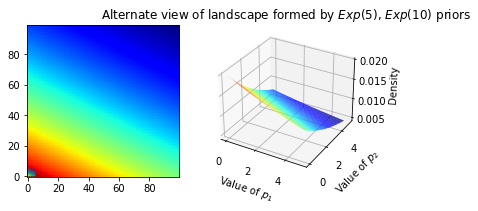

In [20]:
x, y = np.linspace(0, 5, 100), np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

figure = plt.figure()

# Exponential distribution - priors
exp_x = stats.expon.pdf(x, scale=5)
exp_y = stats.expon.pdf(x, scale=10)

M = np.dot(exp_x[:, None], exp_y[None, :])

plt.subplot(121)
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=plt.cm.jet)

ax = figure.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet)
ax.set_xlabel('Value of $p_1$')
ax.set_ylabel('Value of $p_2$')
ax.set_zlabel('Density')
plt.title('Alternate view of landscape formed by $Exp(5)$, $Exp(10)$ priors')
plt.show()

If these surfaces describe our prior distributions on the unknowns, what happens to our space after we incorporate our observed data $X$? 

The data $X$ does **not change the space**, but it **changes the surface of the space** by pulling and stretching the fabric of the prior surface to reflect where the true parameters are likely to be
 - More data means more pulling and stretching, and our original surface may become mangled or insignificant compared to the newly formed surface
 - Less data, and our original shape is more present

Regardless, the **resulting surface describes the new posterior distribution**

The tendency of the observed data to _push up_ the posterior probability in certain areas is checked by the prior probability distribution such that if the prior probability is less for that value, then this means more resistance
 - If the prior probability states a low probability of an outcome in the event space such that their is more resistance near that value

## Exploring the landscape using MCMC

We should explore the posterior space generated by our prior and observed data to find the posterior mountain. However, searching an $N$-dimensional space is exponentially difficult in $N$ (the curse of dimensionality). The size of the space quickly blows up as we increase $N$

The idea behind MCMC is to perform an intelligent search of this space. Search implies we are looking for the most probable range of values (parameters) in our landscape

MCMC returns samples (traces) from the posterior distribution, not the distribution itself. MCMC performs a task similar to repeatedly asking “How likely is this pebble I found to be from the mountain I am searching for?
 - Returning these traces from the posterior distribution, we hope that MCMC will converge toward the areas of posterior probability. MCMC does this by exploring nearby positions and moving into areas with the highest probability. 

Converging usually implies moving forward toward a point in space, but MCMC moves toward a broad area in the space and randomly walks around that area, picking up samples from that area. 

In [4]:
# Observations
N = 100

# The true parameters values for the distributions
lambda_1 = 1
lambda_2 = 3

# Data generation based on the true parameter values - each rvs is in a column (dimension)
data = np.concatenate([stats.poisson.rvs(lambda_1, size=(N, 1)),
                       stats.poisson.rvs(lambda_2, size=(N, 1))],
                       axis=1)

# Plotting details
x = y = np.linspace(.01, 5, 100)

likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x) for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y) for _y in y]).prod(axis=1)

L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

In [9]:
likelihood_x.shape, likelihood_y.shape, L.shape

((100,), (100,), (100, 100))

(0.0, 5.0)

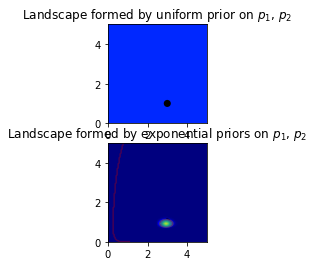

In [14]:
plt.subplot(221)

uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)

M = np.dot(uni_x[:, None], uni_y[None, :])

im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=plt.cm.jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.title('Landscape formed by uniform prior on $p_1$, $p_2$')
plt.scatter(lambda_2, lambda_1, c='k', s=50, edgecolor='None')

plt.subplot(223)
plt.contour(x, y, M*L)
im = plt.imshow(M*L, interpolation='none', origin='lower',
                cmap=plt.cm.jet, extent=(0, 5, 0, 5))

plt.title('Landscape formed by exponential priors on $p_1$, $p_2$')
plt.scatter(lambda_2, lambda_1, c='k', s=50, edgecolor='None')
plt.xlim(0, 5)
plt.ylim(0, 5)

## Markov Chains and Metropolis-Hastings

First, an example involving mosquitos. . .

In [123]:
def mosquito_sequence(day, hop):
    if day == 21:
        return [hop]
    else:
        # Bog 0
        hop = np.random.binomial(1, 0.9)
        if hop == 1:
            print('Day', day, 'Staying in Bog 0')
            mosquito_sequence(day+1, 1)
        # Bog 1
        else:
            print('Day', day, 'Hopped from Bog 0 to Bog 1')
            hop = np.random.binomial(1, 0.8)
            #mosquito_sequence(day+1, 0)
            if hop == 1:
                print('Day', day, 'Staying in Bog 1')
                mosquito_sequence(day+1, 0)
            else:
                print('Day', day, 'Hopping back to Bog 0')
                mosquito_sequence(day+1, 1)

In [124]:
seq = mosquito_sequence(1, 1)

Day 1 Staying in Bog 0
Day 2 Staying in Bog 0
Day 3 Hopped from Bog 0 to Bog 1
Day 3 Staying in Bog 1
Day 4 Staying in Bog 0
Day 5 Staying in Bog 0
Day 6 Staying in Bog 0
Day 7 Staying in Bog 0
Day 8 Staying in Bog 0
Day 9 Staying in Bog 0
Day 10 Staying in Bog 0
Day 11 Staying in Bog 0
Day 12 Staying in Bog 0
Day 13 Staying in Bog 0
Day 14 Staying in Bog 0
Day 15 Hopped from Bog 0 to Bog 1
Day 15 Hopping back to Bog 0
Day 16 Staying in Bog 0
Day 17 Staying in Bog 0
Day 18 Staying in Bog 0
Day 19 Staying in Bog 0
Day 20 Staying in Bog 0
